In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
import os
import pickle
import itertools
import toc_trends_analysis as toc_trends
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from IPython.display import Image

#warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pandas2ri.activate()
bcp = importr('bcp')

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# TOC Thematic Report - February 2019 (Part 6b: analysis of annual trends; relaxed selection criteria)

This notebook implements more-or-less the same workflow as described in notebook 6a, but using a broader range of stations based on less strict selection criteria. See the original notebook for details.

## 1. Select sites

Heleen has suggested applying the same selection criteria as used for the TOC trends analysis with Don and John. This involves aggregating to **annual** frequency and requiring that:

 * There are at least two data points within the first 5 years (start of 1990 to end of 1994)
 * There are at least two data points within the last 5 years (start of 2012 to end of 2016)
 * At least 65% of years have data (i.e. there are at least $0.65 * 27 \approx 18$ non-null datapoints in the aggregated series

In [3]:
# Read stations
stn_path = r'../../../all_icpw_sites_may_2019.xlsx'
stn_df = pd.read_excel(stn_path, sheet_name='all_icpw_stns')
stn_df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


In [4]:
# Load saved chem data
wc_csv = r'../../../Thematic_Trends_Report_2019/working_chem.csv'
wc_df = pd.read_csv(wc_csv, encoding='utf-8')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])
wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,TOC,EH,ESO4,ENO3,ECa_EMg,ANC,ALK-E
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,NaN,3.630781,45.000000,23.571429,64.333333,10.939799,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,NaN,3.630781,47.708333,35.000000,47.166667,-15.749821,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,NaN,2.630268,46.666667,36.428571,81.666667,5.850613,4.0
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,NaN,4.073803,42.083333,32.142857,59.333333,-3.319358,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,NaN,2.089296,38.541667,23.571429,53.500000,3.383879,1.0


In [5]:
# Melt to long format
df = wc_df.copy()
del df['station_code'], df['station_name'], df['depth1'], df['depth2']
df = pd.melt(df, id_vars=['station_id', 'sample_date'])
df.head()

,station_id,sample_date,variable,value
0,23472,1990-10-08,TOC,NaN
1,23472,1993-08-18,TOC,NaN
2,23472,1995-09-05,TOC,NaN
3,23472,1995-09-15,TOC,NaN
4,23472,1997-08-05,TOC,NaN


The code below creates a dataframe showing which series at which sites meet the criteria defined above.

In [6]:
# Dict for results
inc_dict = {'station_id':[],
            'variable':[],
            'include':[],
           }

# Loop over time series
for stn_id in df['station_id'].unique():       
    # Loop over variables
    for par in df['variable'].unique():    
        # Get data
        df2 = df.query("(station_id == @stn_id) and (variable == @par)")
        df2.set_index('sample_date', inplace=True)
        del df2['station_id'], df2['variable']

        # Annual dates from 1990 - 2016
        all_dates = pd.date_range('1990-01-01', '2016-12-31', freq='A')
        dates_df = pd.DataFrame(index=all_dates)

        # Resample to annual
        df2 = df2.resample('A').median()
        df2 = dates_df.join(df2)
        df2.index = df2.index.year

        if pd.isna(df2['value']).all().all():
            # Not suitable
            inc_dict['station_id'].append(stn_id)
            inc_dict['variable'].append(par)
            inc_dict['include'].append('no') 

        else:
            n_start = pd.notnull(df2[df2.index<(1995)]['value']).sum()
            n_end = pd.notnull(df2[df2.index>(2011)]['value']).sum()
            non_missing = pd.notnull(df2['value']).sum()

            if (n_start >= 2) and (n_end >= 2) and (non_missing >= 18):
                # Not suitable
                inc_dict['station_id'].append(stn_id)
                inc_dict['variable'].append(par)
                inc_dict['include'].append('yes') 

            else:
                # Include
                inc_dict['station_id'].append(stn_id)
                inc_dict['variable'].append(par)
                inc_dict['include'].append('no')   

# Build df
inc_df = pd.DataFrame(inc_dict)

print('The number of stations with at least some time series meeting the '
      'specified criteria is', len(inc_df.query('include == "yes"')['station_id'].unique()))

inc_df.head()

The number of stations with at least some time series meeting the specified criteria is 486


,station_id,variable,include
0,23472,TOC,no
1,23472,EH,yes
2,23472,ESO4,yes
3,23472,ENO3,yes
4,23472,ECa_EMg,yes


**486 out of 555** stations have at least one time series (i.e. one parameter) that meets the specified requirements.

In [7]:
# Map of selected stations
sel_stn_list = list(inc_df.query('include == "yes"')['station_id'].unique())
sel_stns = stn_df.query('station_id in @sel_stn_list')
nivapy.spatial.quickmap(sel_stns,
                        cluster=True,
                        popup='station_code')

In [8]:
# Save station list
sel_stns.to_csv(r'../../../Thematic_Trends_Report_2019/results/selected_stations_relaxed_criteria.csv',
                index=False,
                encoding='utf-8')

## 2. M-K and Sen's slope for selected sites

The code below produces a "grid plot" showing the Sen's slope trend estimate for each data series at each site (only data series meeting the selection criteria are included). Each row corresponds to a parameter, and the first column is based on  annual **medians**; the second column uses annual **minima**.

M-K and Sen's slope results for all series are also saved to a CSV file for later use.

In [9]:
%%capture
# Output folder
out_fold = r'../../../Thematic_Trends_Report_2019/results'
    
# Dicts for results
res_dict = {'station_id':[],
            'variable':[],
            'metric':[],
            'mk_p_val':[],
            'mk_trend':[],
            'sen_slp':[],
            'sen_incpt':[],
            'sen_trend':[],
           }

series_dict = {}

for stn_id in inc_df['station_id'].unique():
    # Determine whether to process this site
    inc_site_df = inc_df.query("(station_id == @stn_id) and (include == 'yes')")
    
    if len(inc_site_df) > 0:    
        # Setup plot
        fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20))

        # Loop over variables
        for row_idx, par in enumerate(inc_df['variable'].unique()):
            # Determine whether to plot series
            inc = inc_df.query("(station_id == @stn_id) and (variable == @par)")['include'].values[0]

            if inc == 'no':
                # Plot "omitted" text
                axes[row_idx, 0].text(0.5, 0.5, 
                                      'Omitted due to lack of data',
                                      verticalalignment='center', 
                                      horizontalalignment='center',
                                      transform=axes[row_idx, 0].transAxes,
                                      fontsize=18)

                axes[row_idx, 1].text(0.5, 0.5, 
                                      'Omitted due to lack of data',
                                      verticalalignment='center', 
                                      horizontalalignment='center',
                                      transform=axes[row_idx, 1].transAxes,
                                      fontsize=18)
                
            else:
                # Get data
                df2 = df.query("(station_id == @stn_id) and (variable == @par)")
                df2.set_index('sample_date', inplace=True)
                del df2['station_id'], df2['variable']
                series_dict[(stn_id, par)] = df2                
                
                # Resample to annual medians and mins
                for col_idx, stat in enumerate(['annual median', 'annual minimum']):
                    if stat == 'annual median':
                        df_stat = df2.resample('A').median()
                    else:
                        df_stat = df2.resample('A').min()
                
                    df_stat.index = df_stat.index.year
                    
                    # MK test
                    mk_df = nivapy.stats.mk_test(df_stat, 'value')
                
                    # Sen's slope
                    res_df, sen_df = nivapy.stats.sens_slope(df_stat, 
                                                             value_col='value',
                                                             index_col=df_stat.index)
                
                    # Add results to dict
                    res_dict['station_id'].append(stn_id)
                    res_dict['variable'].append(par)
                    res_dict['metric'].append(stat)
                    res_dict['mk_p_val'].append(mk_df.loc['p'].value)
                    res_dict['mk_trend'].append(mk_df.loc['trend'].value)
                    
                    sslp = res_df.loc['sslp'].value
                    sincpt = res_df.loc['icpt'].value
                    res_dict['sen_slp'].append(sslp)
                    res_dict['sen_incpt'].append(sincpt)
                    res_dict['sen_trend'].append(res_df.loc['trend'].value)
                                        
                    # Plot
                    axes[row_idx, col_idx].plot(sen_df.index, sen_df['value'].values, 'bo-')
                    axes[row_idx, col_idx].plot(sen_df.index, 
                                                sen_df.index*sslp + sincpt, 'k-')                
                
            if par == 'TOC':
                unit = 'mg-C/l'
            else:
                unit = 'µEq/l'
                
            axes[row_idx, 0].set_title('Annual median %s (%s)' % (par, unit))
            axes[row_idx, 1].set_title('Annual minimum %s (%s)' % (par, unit))
        
        plt.tight_layout()
        
        # Save
        out_png = os.path.join(out_fold, 'trends_plots_1990-2016_relaxed_criteria/%s_trends_1990-2016_relaxed_criteria.png' % stn_id)
        plt.savefig(out_png, dpi=200)
        plt.close()        

# Combine results
res_df = pd.DataFrame(res_dict)
out_csv = os.path.join(out_fold, 'trends_summary_1990-2016_relaxed_criteria.csv')
res_df.to_csv(out_csv, index=False, encoding='utf-8')

# Save series
out_pkl = os.path.join(out_fold, 'series_relaxed_criteria.pkl')
with open(out_pkl, 'wb') as handle:
    pickle.dump(series_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
res_df.head()

,station_id,variable,metric,mk_p_val,mk_trend,sen_slp,sen_incpt,sen_trend
0,23472,EH,annual median,0.004075,decreasing,-0.069545,141.432722,decreasing
1,23472,EH,annual minimum,0.005565,decreasing,-0.061452,124.796353,decreasing
2,23472,ESO4,annual median,0.000001,decreasing,-0.920324,1876.644477,decreasing
3,23472,ESO4,annual minimum,0.000005,decreasing,-0.974359,1983.006410,decreasing
4,23472,ENO3,annual median,0.141726,no trend,-0.416541,862.736852,no trend


## 3. Comparison of trends in annual means and annual minima for EH, ANC, alkalinity

Øyvind would like to know whether the trends in medians and minima are consistent. One way to do this is to plot the Sen's slopes derived from medians against those based on minima, split by parameter. Øyvind is primarily interested in EH, ANC, alkalinity, so I'll just focus on those here.

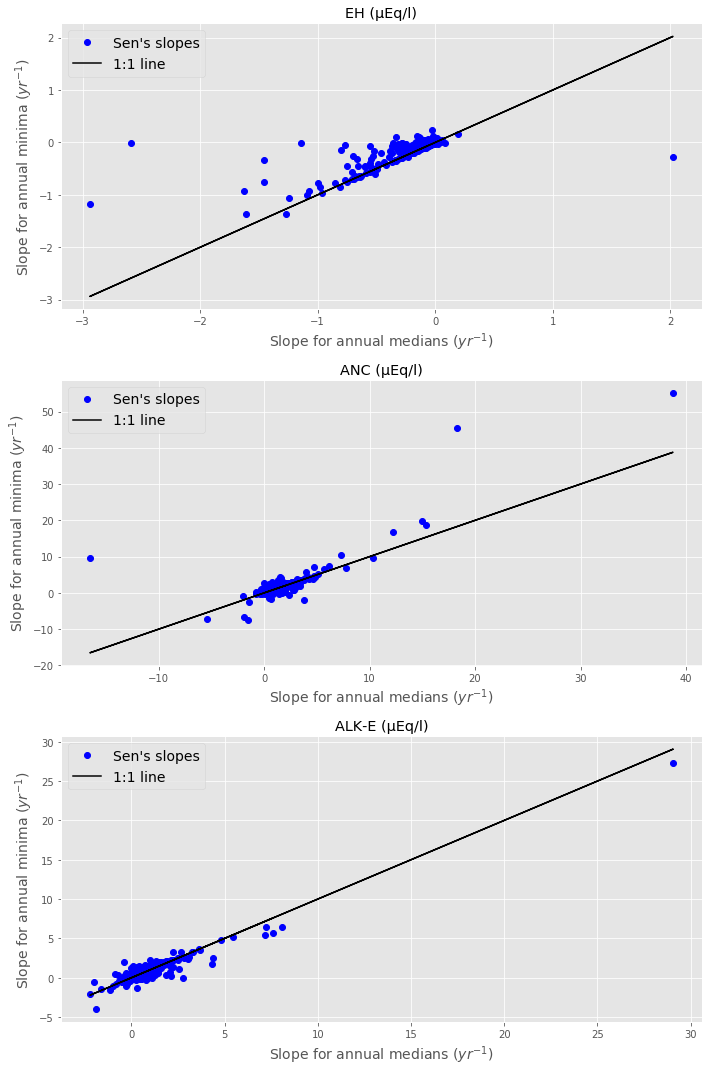

In [11]:
# Cols of interest
cols = ['station_id', 'variable', 'metric', 'sen_slp']

# Setup plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,15))

# Loop over pars
for idx, par in enumerate(['EH', 'ANC', 'ALK-E']):
    # Get data
    cols = ['station_id', 'variable', 'metric', 'sen_slp']
    comp_df = res_df.query("variable == @par")[cols].copy()
    del comp_df['variable']
    comp_df.set_index(['station_id', 'metric'], inplace=True)
    
    # Convert to 'wide' format
    comp_df = comp_df.unstack('metric')
    comp_df.columns = comp_df.columns.get_level_values('metric')

    # Plot
    axes[idx].plot(comp_df['annual median'], comp_df['annual minimum'], 'bo', label="Sen's slopes")
    axes[idx].plot(comp_df['annual median'], comp_df['annual median'], 'k-', label='1:1 line')
    axes[idx].set_xlabel('Slope for annual medians ($yr^{-1}$)', fontsize=14)
    axes[idx].set_ylabel('Slope for annual minima ($yr^{-1}$)', fontsize=14)
    axes[idx].legend(loc='best', fontsize=14)
    axes[idx].set_title('%s (µEq/l)' % par)

plt.tight_layout()

# Save
out_png = os.path.join(out_fold, 'trend_minima_vs_medians_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

In general, the **slopes obtained from annual medians are very similar to those based on annual minima**.

**Note:** There are a few outliers on the plots above that probably warrant further investigation.

Another visualisation option is to create **heatmaps** showing whether trends in annual minima are classified as being "significant" in the same way as trends in annual medians. The labels on the plots below show the percentage of the total sites for each variable in each of 9 classes. High proportions along the diagonal indicate that results based on minima and medians are giving essentially the same overall picture. The overall direction of the trends is also very clear.

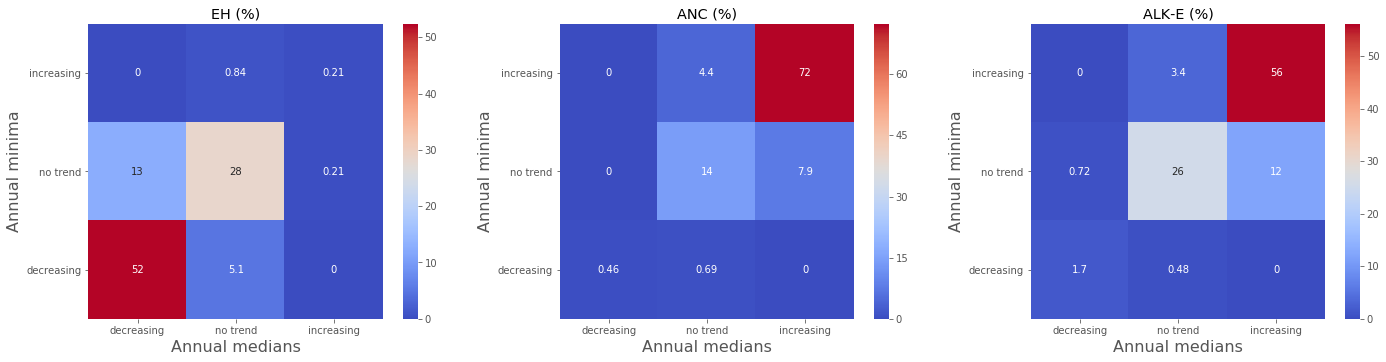

In [12]:
# Cols of interest
cols = ['station_id', 'variable', 'metric', 'sen_trend']

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Loop over pars
for idx, par in enumerate(['EH', 'ANC', 'ALK-E']):
    # Get data
    cols = ['station_id', 'variable', 'metric', 'sen_trend']
    comp_df = res_df.query("variable == @par")[cols].copy()
    del comp_df['variable']
    comp_df.set_index(['station_id', 'metric'], inplace=True)
    
    # Convert to 'wide' format
    comp_df = comp_df.unstack('metric')
    comp_df.columns = comp_df.columns.get_level_values('metric')
    comp_df.columns = [i.replace(' ', '_') for i in comp_df.columns]
    
    # Get counts for combos
    opt_list = ['decreasing', 'no trend', 'increasing']
    hmap = np.zeros(shape=(3,3))
    
    # Map options to array indices (med is x; min is y)
    med_map = {'decreasing':0,
               'no trend':1,
               'increasing':2,
              }
    
    min_map = {'decreasing':2,
               'no trend':1,
               'increasing':0,
              }
    
    # Assign counts to array
    for pair in itertools.product(opt_list, repeat=2):
        ann_med, ann_min = pair
        cnt = len(comp_df.query("(annual_median == @ann_med) and (annual_minimum == @ann_min)"))
        pct = 100*cnt/len(comp_df)
        hmap[min_map[ann_min], med_map[ann_med]] = pct

    # Plot
    g = sn.heatmap(hmap, 
                   ax=axes[idx], 
                   square=True, 
                   annot=True,
                   xticklabels=opt_list,
                   yticklabels=opt_list[::-1],
                   cmap='coolwarm',
                  )
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    
    axes[idx].set_xlabel('Annual medians', fontsize=16)
    axes[idx].set_ylabel('Annual minima', fontsize=16)
    axes[idx].set_title('%s (%%)' % par)

plt.tight_layout()

# Save
out_png = os.path.join(out_fold, 'trend_minima_vs_medians_heatmap_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

## 4. Summarising by region

To present results concisely, we need to aggregate output from the analysis above. A simple way to get an overall picture of the dataset is to create box plots, violin plots and histograms illustrating the **range of *significant* Sen's slopes** for each parameter in each region (or country or continent). I will **focus on annual medians** here since, based on the output above, results for minima should be similar.

In [13]:
# Get data
reg_df = res_df.query("(metric == 'annual median') and "
                      "(sen_trend in ('increasing', 'decreasing'))")

# Join regions
reg_df = pd.merge(reg_df, stn_df[['station_id', 'continent', 'country', 'region']],
                  how='left', on='station_id')

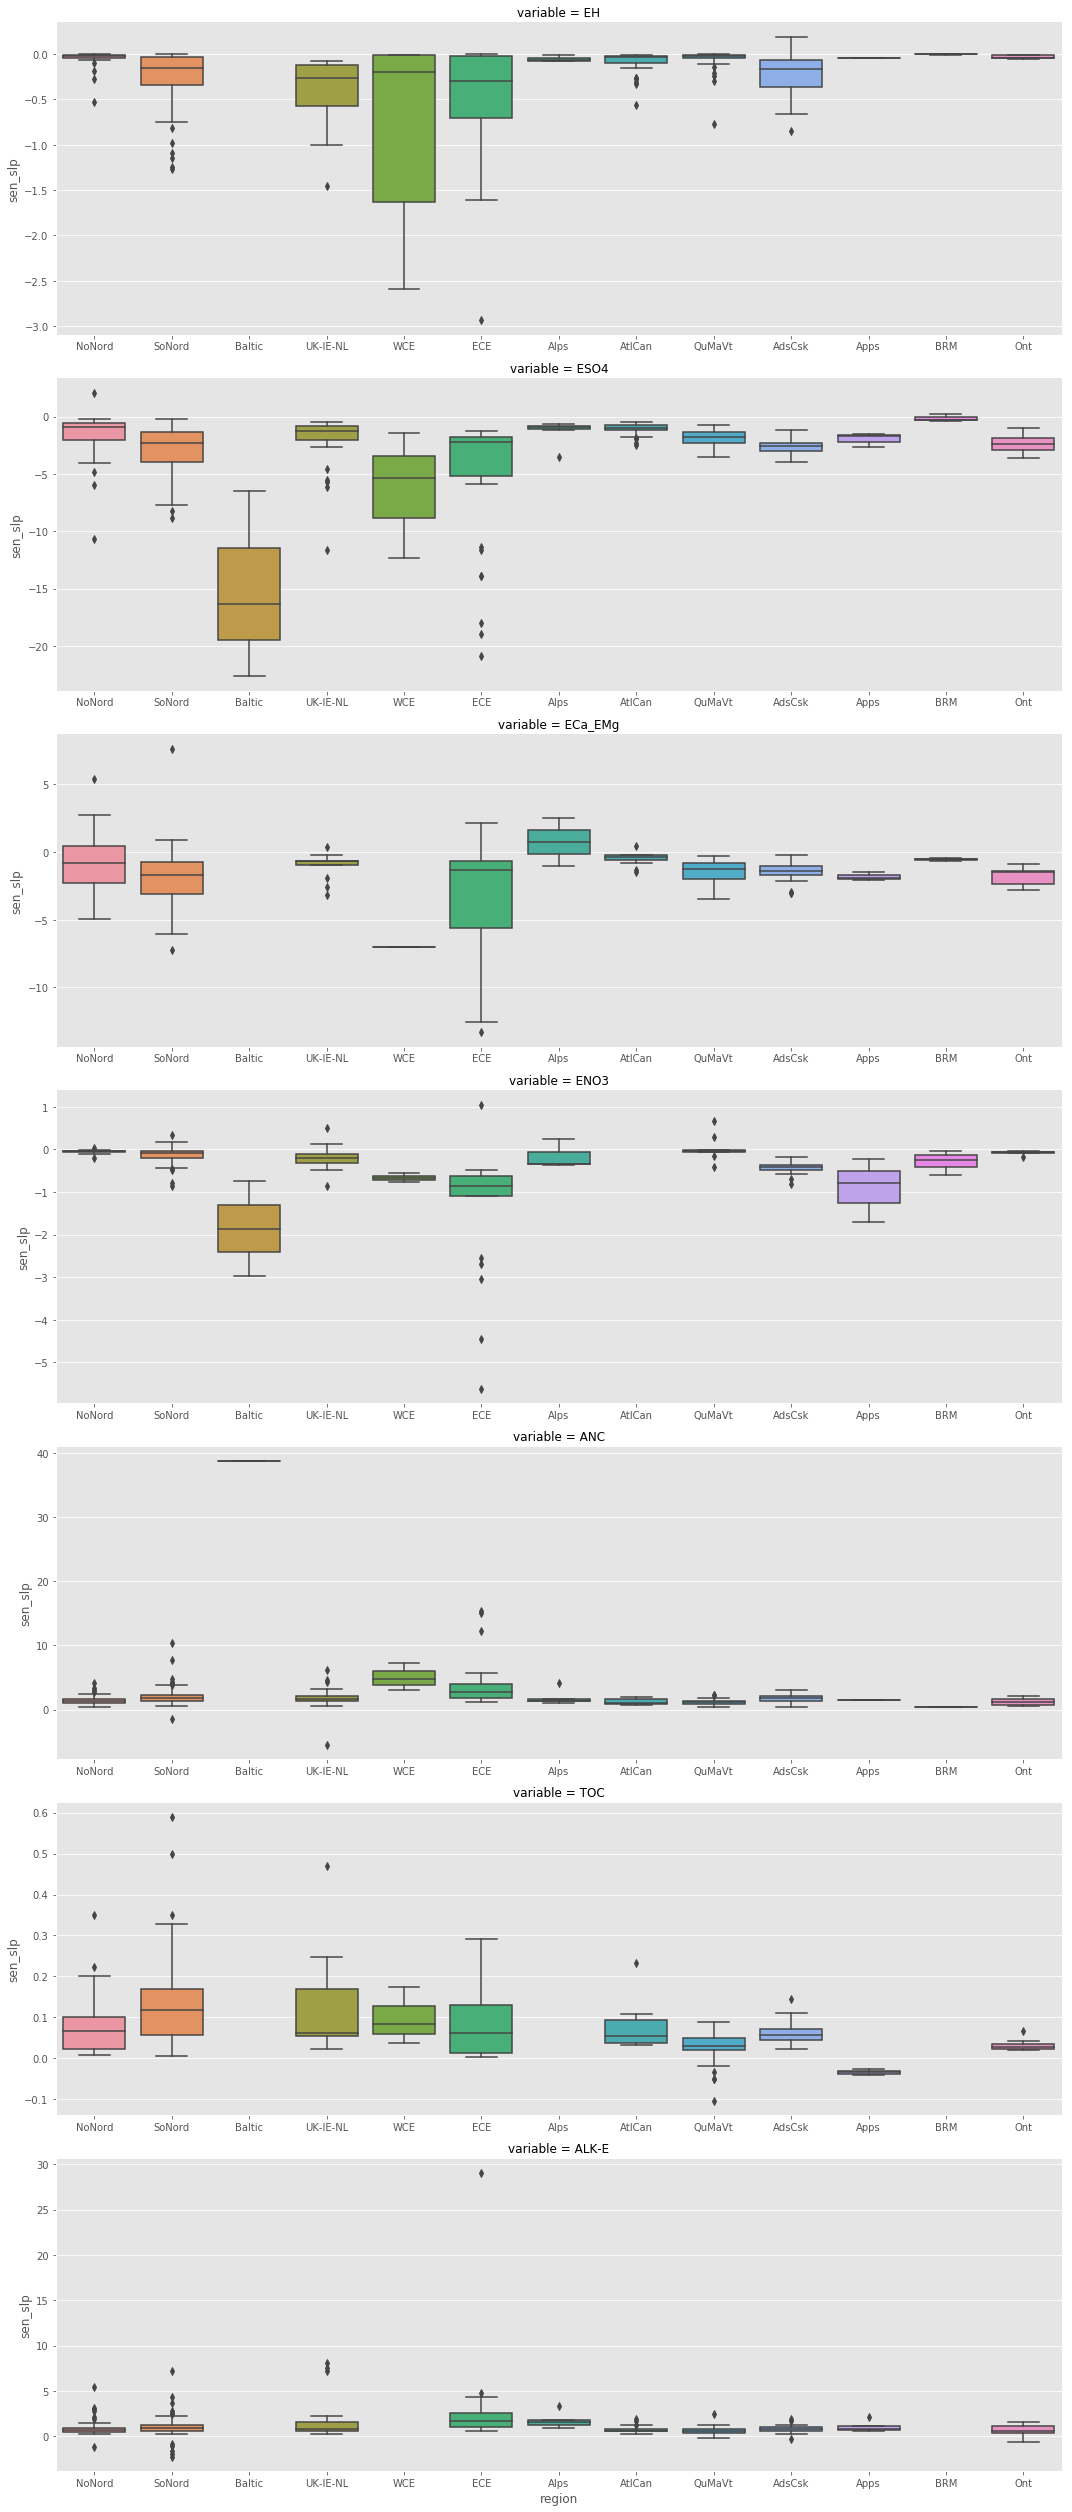

In [14]:
# Boxplots by region
g = sn.catplot(data=reg_df,
               row='variable',
               x='region',
               y='sen_slp',
               kind='box',
               order=['NoNord', 'SoNord', 'Baltic', 'UK-IE-NL', 
                      'WCE', 'ECE', 'Alps', 'AtlCan', 'QuMaVt',
                      'AdsCsk', 'Apps', 'BRM', 'Ont'],
               sharex=False,
               sharey=False,
               aspect=3
              )

# Save
out_png = os.path.join(out_fold, 'slope_box_plots_by_region_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

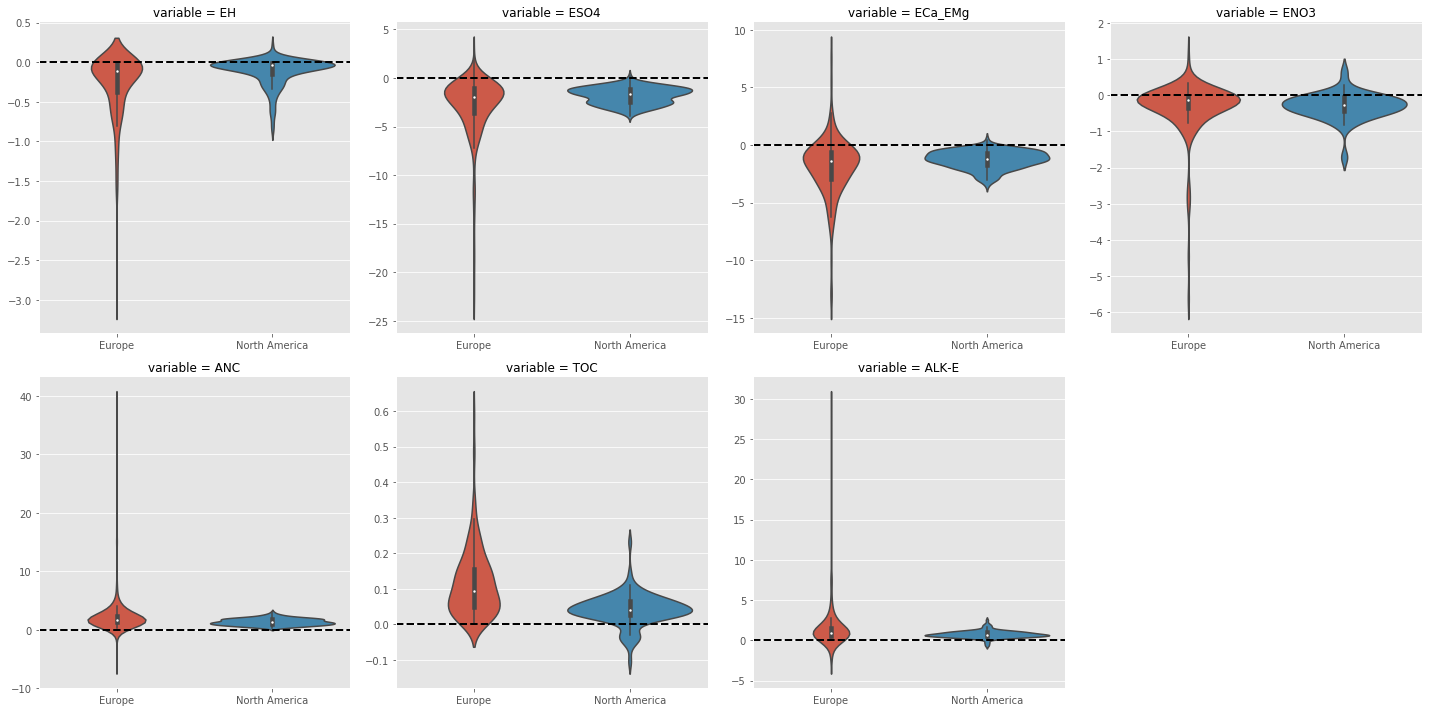

In [15]:
# Violin plots by continent
g = sn.catplot(data=reg_df,
               col='variable',
               col_wrap=4,
               x='continent',
               y='sen_slp',
               kind='violin',
               sharex=False,
               sharey=False,
               aspect=1
              )

g.map(plt.axhline, y=0, lw=2, ls='--', c='k')

# Save
out_png = os.path.join(out_fold, 'slope_violin_plots_by_continent_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

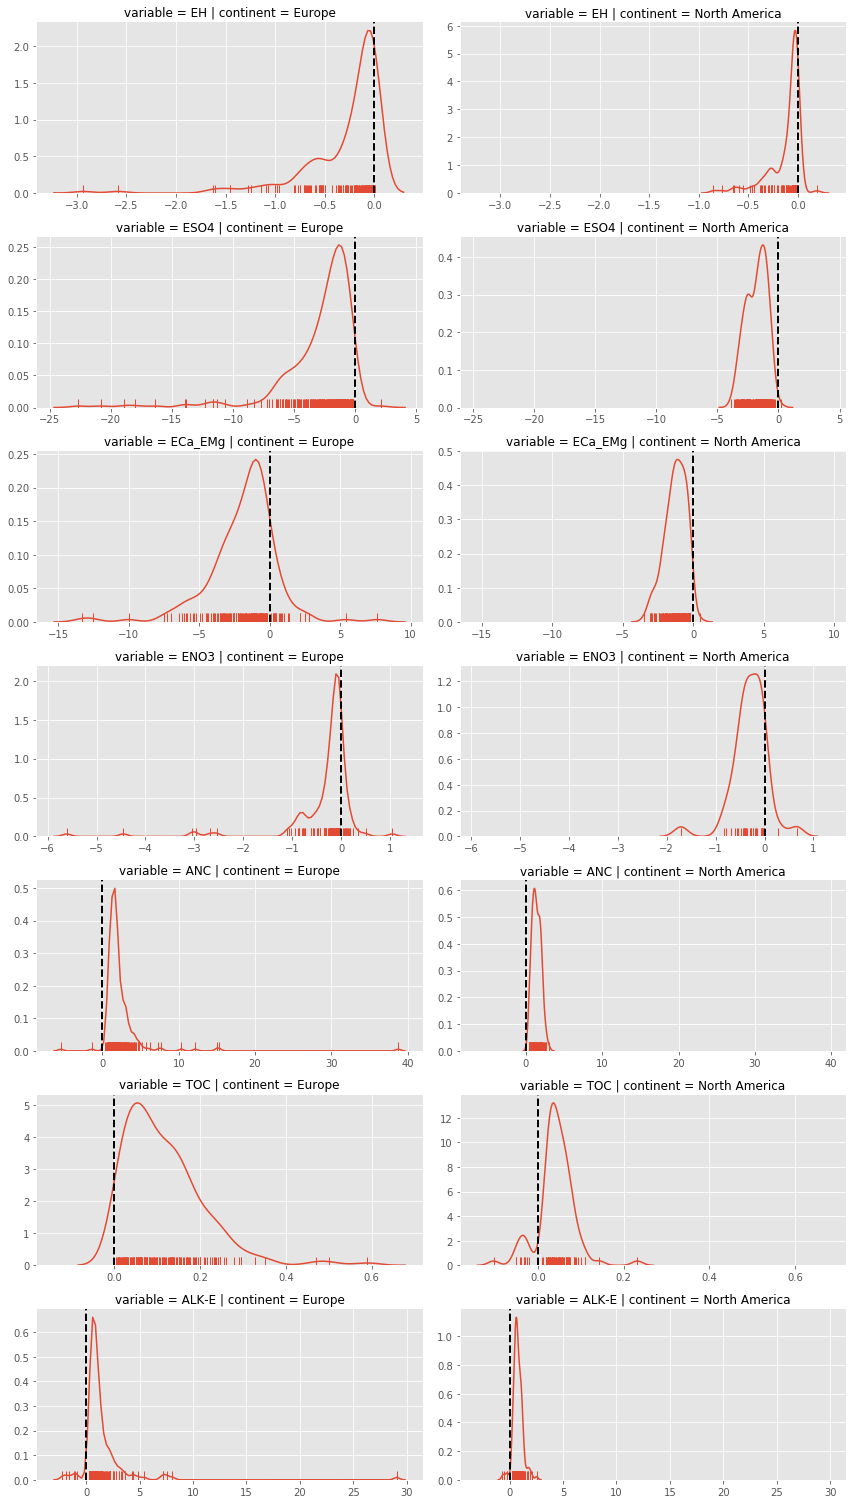

In [16]:
# KDE-smoothed plots by continent
g = sn.FacetGrid(reg_df,
                 row="variable",
                 col='continent',
                 aspect=2,
                 sharex='row',
                 sharey=False)
g.map(sn.distplot, 'sen_slp', hist=False, rug=True)
g.map(plt.axvline, x=0, lw=2, ls='--', c='k')

# Save
out_png = os.path.join(out_fold, 'slope_kde_plots_by_continent_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

Remember that all the plots above are different ways of illustrating the distributions of *significant* Sen's slopes. I think there are some interesting patterns here - especially comparing Europe with North America.

## 4b. Regional M-K and Sen's slope tests

**Added 27/06/2019**

I have now extended `nivapy.stats` to include the regionl/seasonal Mann-Kendall test, plus a regional/seasoanl estimate of the Sen's slope - see `nivapy.stats.seasonal_regional_mk_sen()` for details. The code below estimate regional trends in each region for each parameter, based on the 486 stations meeting the selection criteria.

In [17]:
%%capture

res_dict = {'region':      [],
            'param':       [],
            'stat':        [],
            'n_stns':      [],
            'mk_stat':     [],
            'mk_stat_var': [],
            'mk_pval':     [],
            'sen_slp':     [],
            'mk_trend':    [],
            }

# Loop over parameters
for par in inc_df['variable'].unique():
    # Get stations to include for this parameter
    stns_par = inc_df.query('(variable == @par) and (include == "yes")')['station_id']
    stns_par = stn_df.query('station_id in @stns_par')
    
    # Loop over regions
    for reg in stns_par['region'].unique():
        stns_reg = stns_par.query('region == @reg')['station_id']
        n_stns_reg = len(stns_reg)
        
        # Get data
        df2 = df.query('(station_id in @stns_reg) and (variable == @par)').copy()
        df2['year'] = df2['sample_date'].dt.year
        del df2['sample_date'], df2['variable']
        
        # Consider medians and minima
        for stat in ['annual median', 'annual minimum']:
            if stat == 'annual median':
                df3 = df2.groupby(['station_id', 'year']).median().reset_index()
            else:
                df3 = df2.groupby(['station_id', 'year']).min().reset_index()

            # Regional M-K test
            res_df = nivapy.stats.seasonal_regional_mk_sen(df3, 
                                                           time_col='year',
                                                           value_col='value',
                                                           block_col='station_id')  

            # Append to results
            res_dict['region'].append(reg)
            res_dict['param'].append(par)
            res_dict['stat'].append(stat)
            res_dict['n_stns'].append(n_stns_reg)
            res_dict['mk_stat'].append(res_df.loc['s']['value'])
            res_dict['mk_stat_var'].append(res_df.loc['var_s']['value'])
            res_dict['mk_pval'].append(res_df.loc['p']['value'])
            res_dict['sen_slp'].append(res_df.loc['sslp']['value'])
            res_dict['mk_trend'].append(res_df.loc['trend']['value'])
                
res_df = pd.DataFrame(res_dict)

# Save
out_path = os.path.join(out_fold, 'regional_mk_sen_slope_relaxed_criteria.csv')
res_df.to_csv(out_path, encoding='utf-8', index=False)

In [18]:
res_df.head(10)

,region,param,stat,n_stns,mk_stat,mk_stat_var,mk_pval,sen_slp,mk_trend
0,Ont,TOC,annual median,15,2036.0,32483.333333,0.0,0.022300,increasing
1,Ont,TOC,annual minimum,15,2392.0,32424.000000,0.0,0.029273,increasing
2,QuMaVt,TOC,annual median,61,3704.0,117162.000000,0.0,0.017857,increasing
3,QuMaVt,TOC,annual minimum,61,4395.0,117029.666667,0.0,0.022222,increasing
4,AtlCan,TOC,annual median,63,3567.0,135021.000000,0.0,0.033515,increasing
5,AtlCan,TOC,annual minimum,63,5692.0,134820.000000,0.0,0.055556,increasing
6,ECE,TOC,annual median,27,2182.0,40152.666667,0.0,0.016464,increasing
7,ECE,TOC,annual minimum,27,1907.0,40129.666667,0.0,0.014286,increasing
8,SoNord,TOC,annual median,145,22899.0,323536.333333,0.0,0.069444,increasing
9,SoNord,TOC,annual minimum,145,22396.0,322879.333333,0.0,0.066667,increasing


## 5. Change points

The code below uses the BCP R package and is modified from [notebook 5](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part5_hi_freq.ipynb). 

For each of the selected time series at each site, I will run a change point analysis (without regression - see [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part5_hi_freq.ipynb#3.-BCP-package-in-R) for details) and produce a single plot showing all the data for each site. For each variable, I will also record years when the probabiltiy of change is (i) greater than 50% and (ii) greater than 75%. This will make it possible to look for consistent change points across regions. 

In [19]:
def listvector_to_dict(lv):
    """ Convert R ListVector to a Python dict.
    """
    return dict(zip(lv.names, map(list,list(lv))))

def plot_bcp_change_pts(stn_id, reg=True, p0=0.2):
    """ Run BCP analysis to detect change-points.
    """
    res_dict = {'station_id':[],
                'variable':[],
                'prob':[],
                'year':[],
               }
    
    # Setup plot
    fig, axes = plt.subplots(nrows=7, ncols=2, 
                             sharex=False,
                             sharey=False,
                             figsize=(15,15))
    
    # Loop over variables
    for row_idx, par in enumerate(inc_df['variable'].unique()):
        # Determine whether to plot series
        inc = inc_df.query("(station_id == @stn_id) and (variable == @par)")['include'].values[0]

        if inc == 'no':
            # Plot "omitted" text
            axes[row_idx, 0].text(0.5, 0.5, 
                                  'Omitted due to lack of data',
                                  verticalalignment='center', 
                                  horizontalalignment='center',
                                  transform=axes[row_idx, 0].transAxes,
                                  fontsize=18)
            axes[row_idx, 0].set_ylabel(par)

            axes[row_idx, 1].text(0.5, 0.5, 
                                  'Omitted due to lack of data',
                                  verticalalignment='center', 
                                  horizontalalignment='center',
                                  transform=axes[row_idx, 1].transAxes,
                                  fontsize=18)
            axes[row_idx, 1].set_ylabel('Probability')
            
        else:
            # Get data
            df2 = df.query("(station_id == @stn_id) and (variable == @par)")
            df2.set_index('sample_date', inplace=True)
            del df2['station_id'], df2['variable']
    
            # Resample
            df2 = df2.resample('A').median().reset_index()
            df2['year'] = df2['sample_date'].dt.year
            del df2['sample_date']

            # Interpolate years with missing data
            index_df = pd.DataFrame({'year':range(1990, 2017)})
            df2 = pd.merge(index_df, df2, how='left', on='year')
            df2.interpolate(kind='linear', inplace=True)

            # Change point analysis
            if reg:
                # Perform regression within each partition
                res = bcp.bcp(df2['value'], 
                              x=df['year'], 
                              p0=p0)
            else:
                # Assume constant mean within each partition
                res = bcp.bcp(df2['value'], 
                              p0=p0)            

            res = listvector_to_dict(res)

            res = pd.DataFrame({'raw':df2['value'].values,
                                'mean':res['posterior.mean'],
                                'prob':res['posterior.prob']},
                               index=df2['year'].values)

            # Add to results
            gt50 = np.array(res.index[res['prob'] > 0.5])
            for year in gt50:                        
                res_dict['station_id'].append(stn_id)
                res_dict['variable'].append(par)
                res_dict['prob'].append('gt50')
                res_dict['year'].append(year)
            
            gt75 = np.array(res.index[res['prob'] > 0.75])
            for year in gt75:                        
                res_dict['station_id'].append(stn_id)
                res_dict['variable'].append(par)
                res_dict['prob'].append('gt75')
                res_dict['year'].append(year)  
                
            # Plot
            res['raw'].plot(ax=axes[row_idx, 0], marker='o', linestyle=':', label='Raw')
            res['mean'].plot(ax=axes[row_idx, 0], label='Fitted')
            axes[row_idx, 0].set_ylabel(par)
            axes[row_idx, 0].legend(loc='best')

            res['prob'].plot(ax=axes[row_idx, 1], marker='o')
            axes[row_idx, 1].set_ylabel('Probability')
            axes[row_idx, 1].set_ylim((0, 1))
            axes[row_idx, 1].axhline(0.5, c='k', linestyle='--')
            axes[row_idx, 1].axhline(0.95, c='k', linestyle='--')

        axes[0, 0].set_title('Data series')    
        axes[0, 1].set_title('Change probability')
        
    plt.tight_layout()
    out_png = os.path.join(out_fold, 'bcp_selected_sites_relaxed_criteria/bcp_stn_%s_relaxed_criteria.png' % stn_id)
    plt.savefig(out_png, dpi=200)
    plt.close()
    
    res_df = pd.DataFrame(res_dict)
    
    return res_df

In [20]:
%%capture
# Container for results
df_list = []

# Loop over stations
for stn_id in inc_df['station_id'].unique():
    # Determine whether to process this site
    inc_site_df = inc_df.query("(station_id == @stn_id) and (include == 'yes')")
    
    if len(inc_site_df) > 0: 
        # Run BCP
        res_bcp = plot_bcp_change_pts(stn_id, reg=False, p0=0.1)  
        df_list.append(res_bcp)
        
# Combine results
res_bcp = pd.concat(df_list, axis=0)

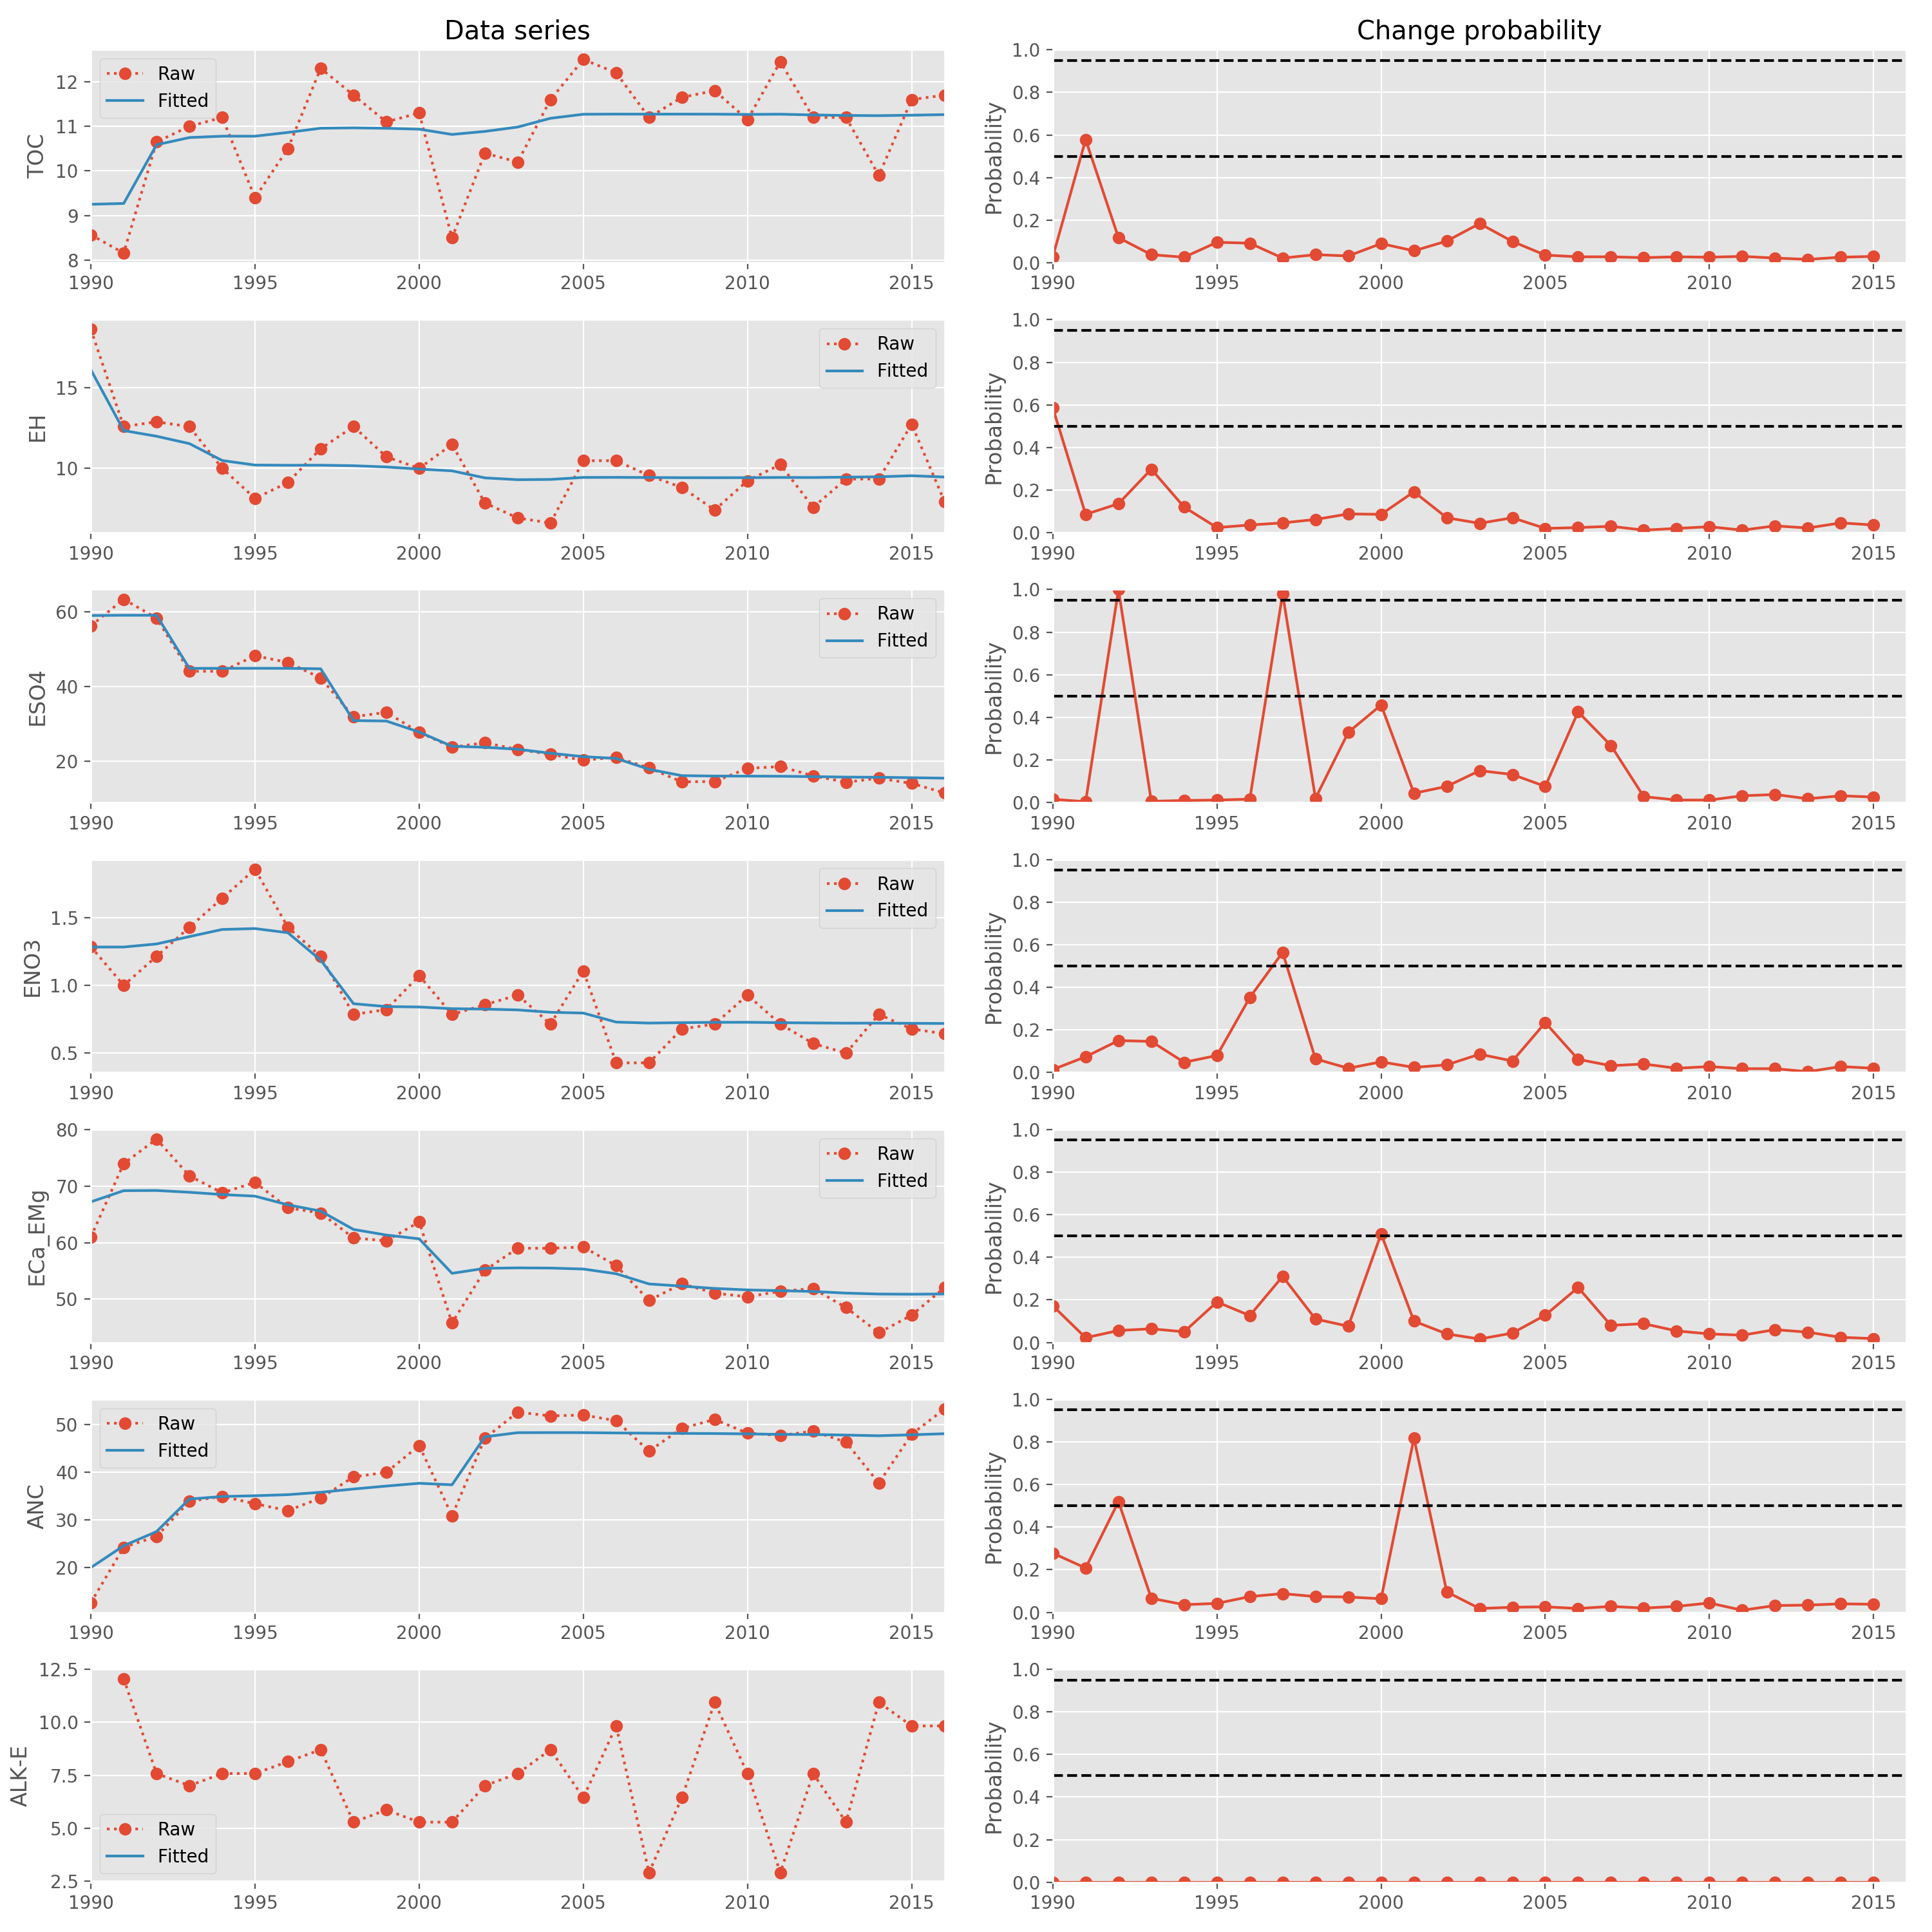

In [21]:
# Show example BCP output
Image(r'../../../Thematic_Trends_Report_2019/results/bcp_selected_sites_relaxed_criteria/bcp_stn_38242_relaxed_criteria.png')

These results can now be aggregated regionally. I will produce four sets of plots:

 1. KDE-smoothed histograms showing years where the probabiltiy of change is **>50%**
 
  a. Split by region  
  
  b. Split by continent
   
 2. KDE-smoothed histograms showing years where the probabiltiy of change is **>75%**
 
  a. Split by region
  
  b. Split by continent
  
For ease of comparison, columns represent parameters and rows are regions. Considering one column at a time therefore makes it posible to identify for similar patterns between regions.

In [22]:
# Join regions
res_bcp = pd.merge(res_bcp, stn_df[['station_id', 'continent', 'country', 'region']],
                   how='left', on='station_id')

res_bcp.head()

,station_id,variable,prob,year,continent,country,region
0,23472.0,EH,gt50,1996.0,Europe,Switzerland,Alps
1,23472.0,EH,gt50,2005.0,Europe,Switzerland,Alps
2,23472.0,EH,gt50,2006.0,Europe,Switzerland,Alps
3,23472.0,EH,gt75,2005.0,Europe,Switzerland,Alps
4,23472.0,EH,gt75,2006.0,Europe,Switzerland,Alps


/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


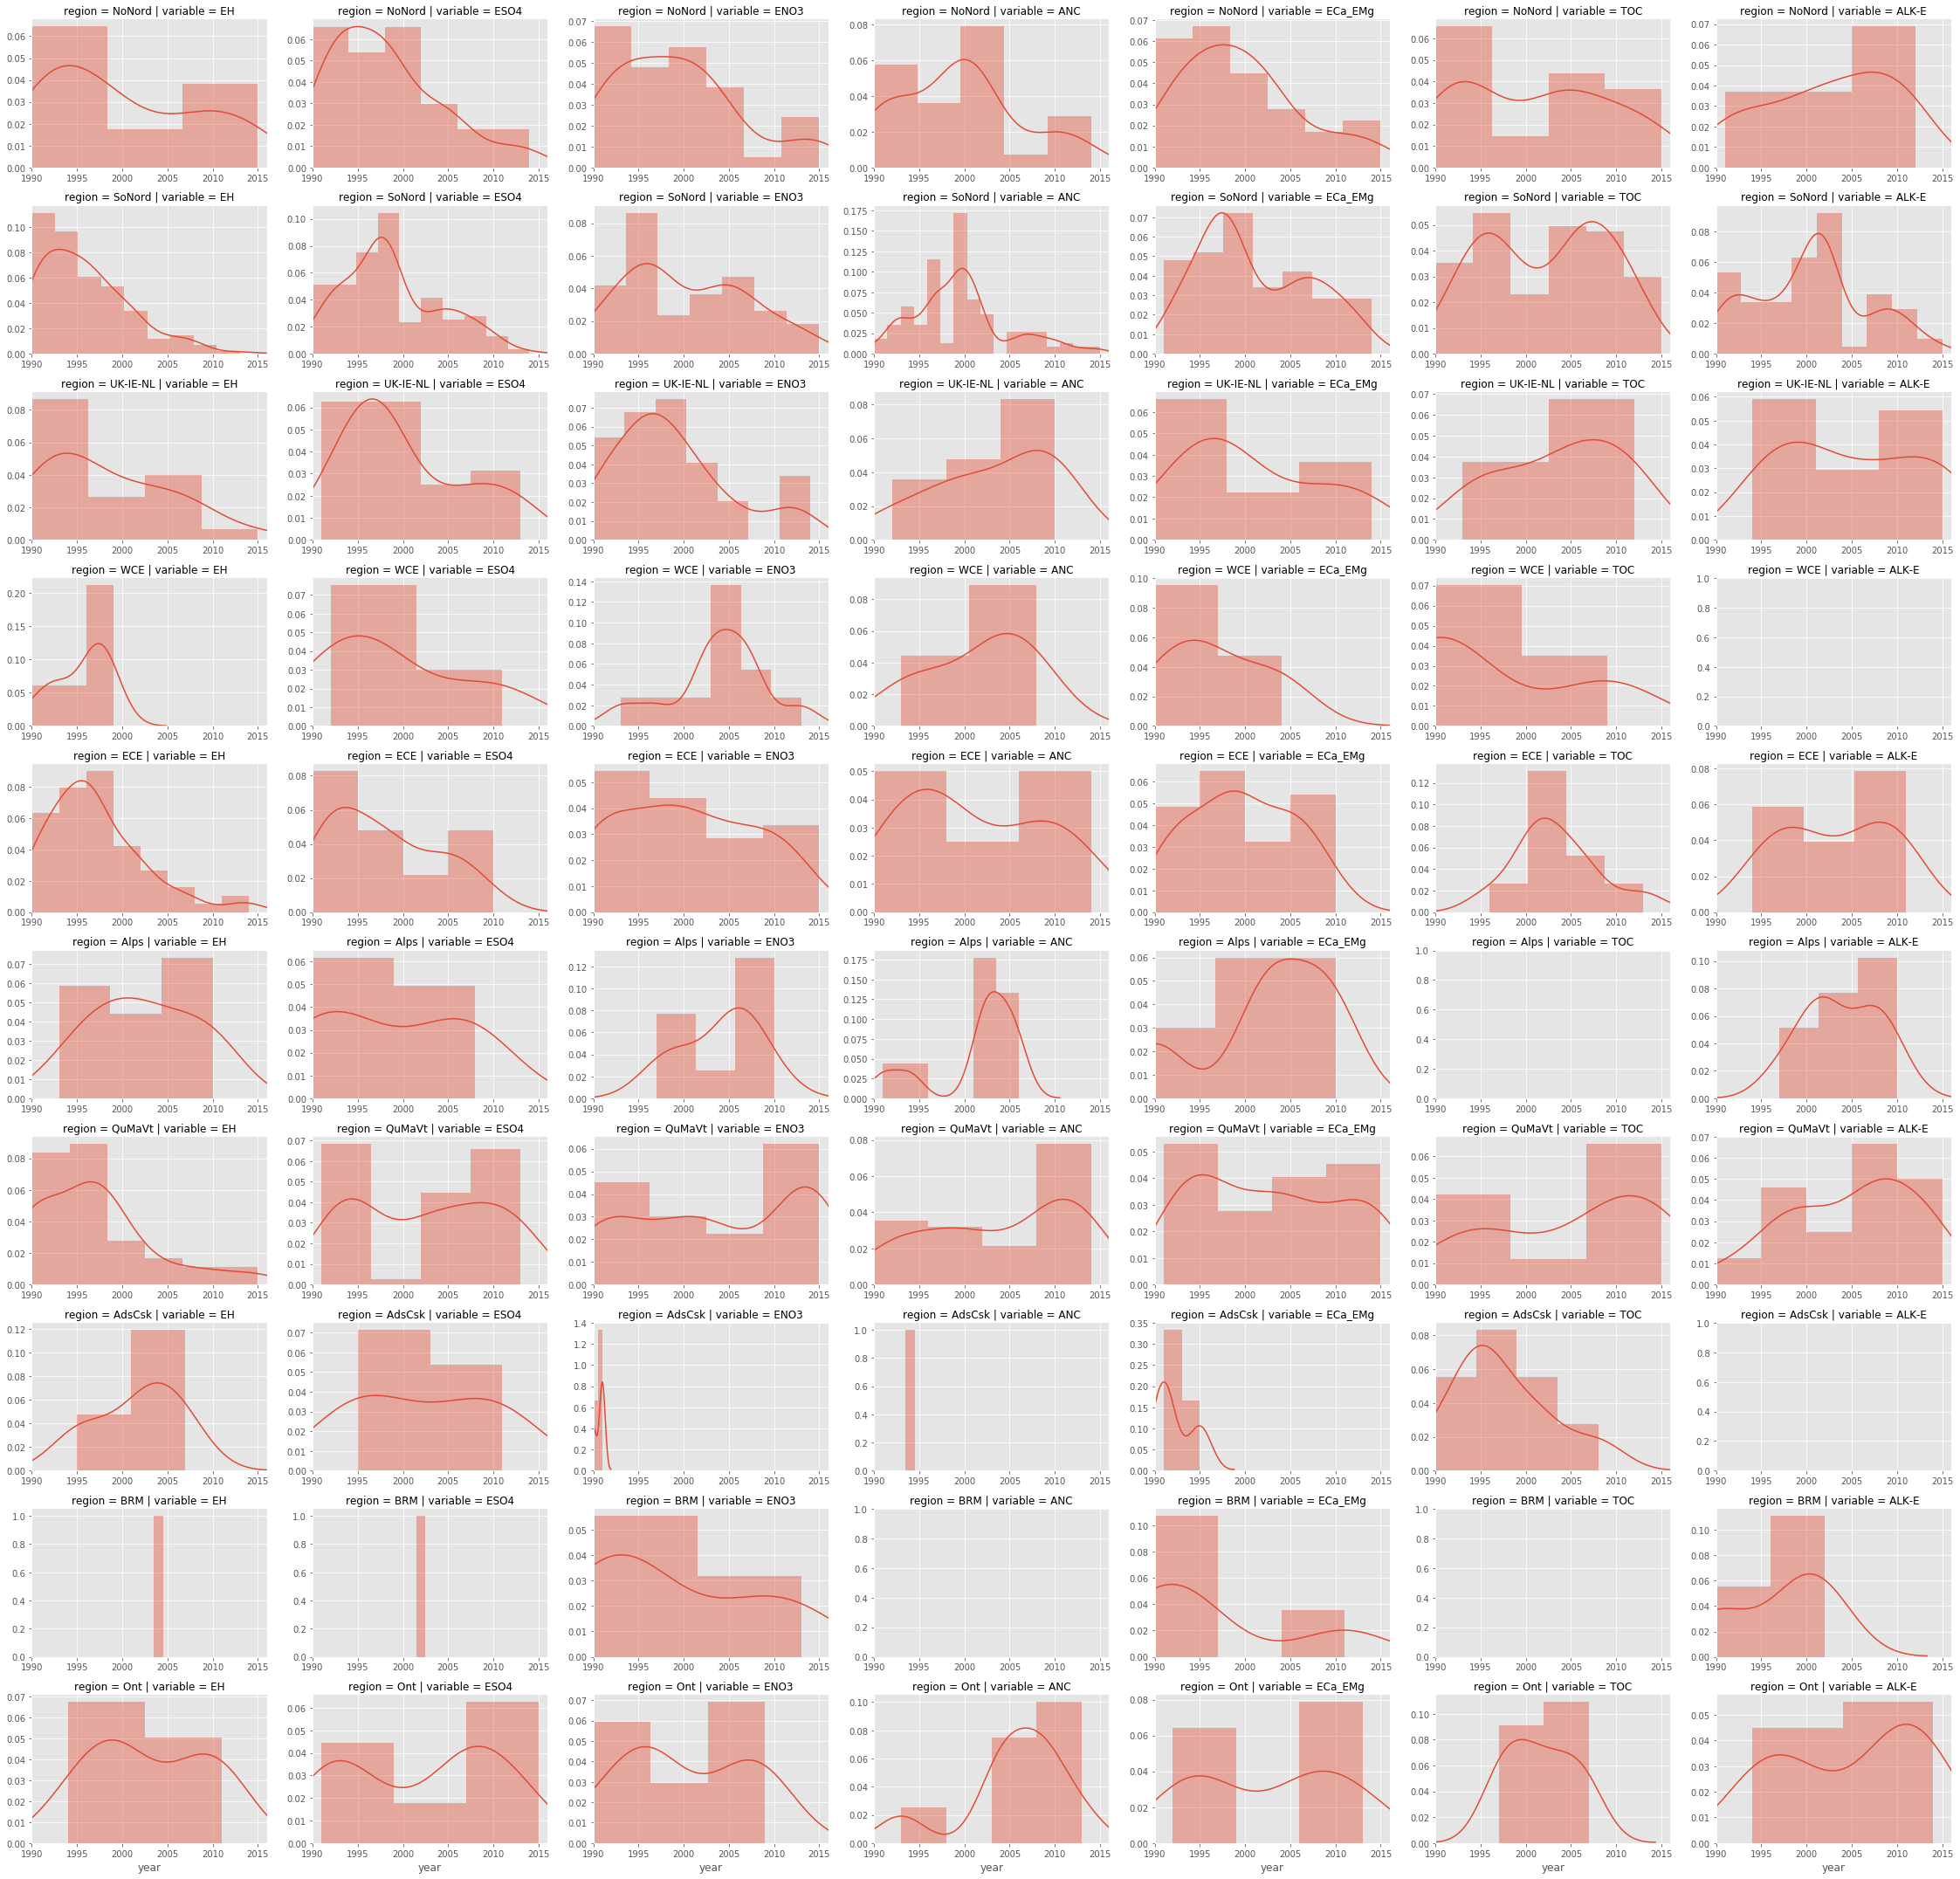

In [23]:
# KDE-smoothed plots by region
# Change prob > 50%
gt50_df = res_bcp.query('prob == "gt50"')

g = sn.FacetGrid(gt50_df,
                 row='region',
                 col='variable',
                 aspect=1.5,
                 sharex='row',
                 sharey=False,
                 row_order=['NoNord', 'SoNord', 'UK-IE-NL', 
                            'WCE', 'ECE', 'Alps', 'QuMaVt',
                            'AdsCsk', 'BRM', 'Ont'])
g.map(sn.distplot, 'year')
g.set(xlim=(1990, 2016))

# Save
out_png = os.path.join(out_fold, 'change_prob_kde_gt50_by_region_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

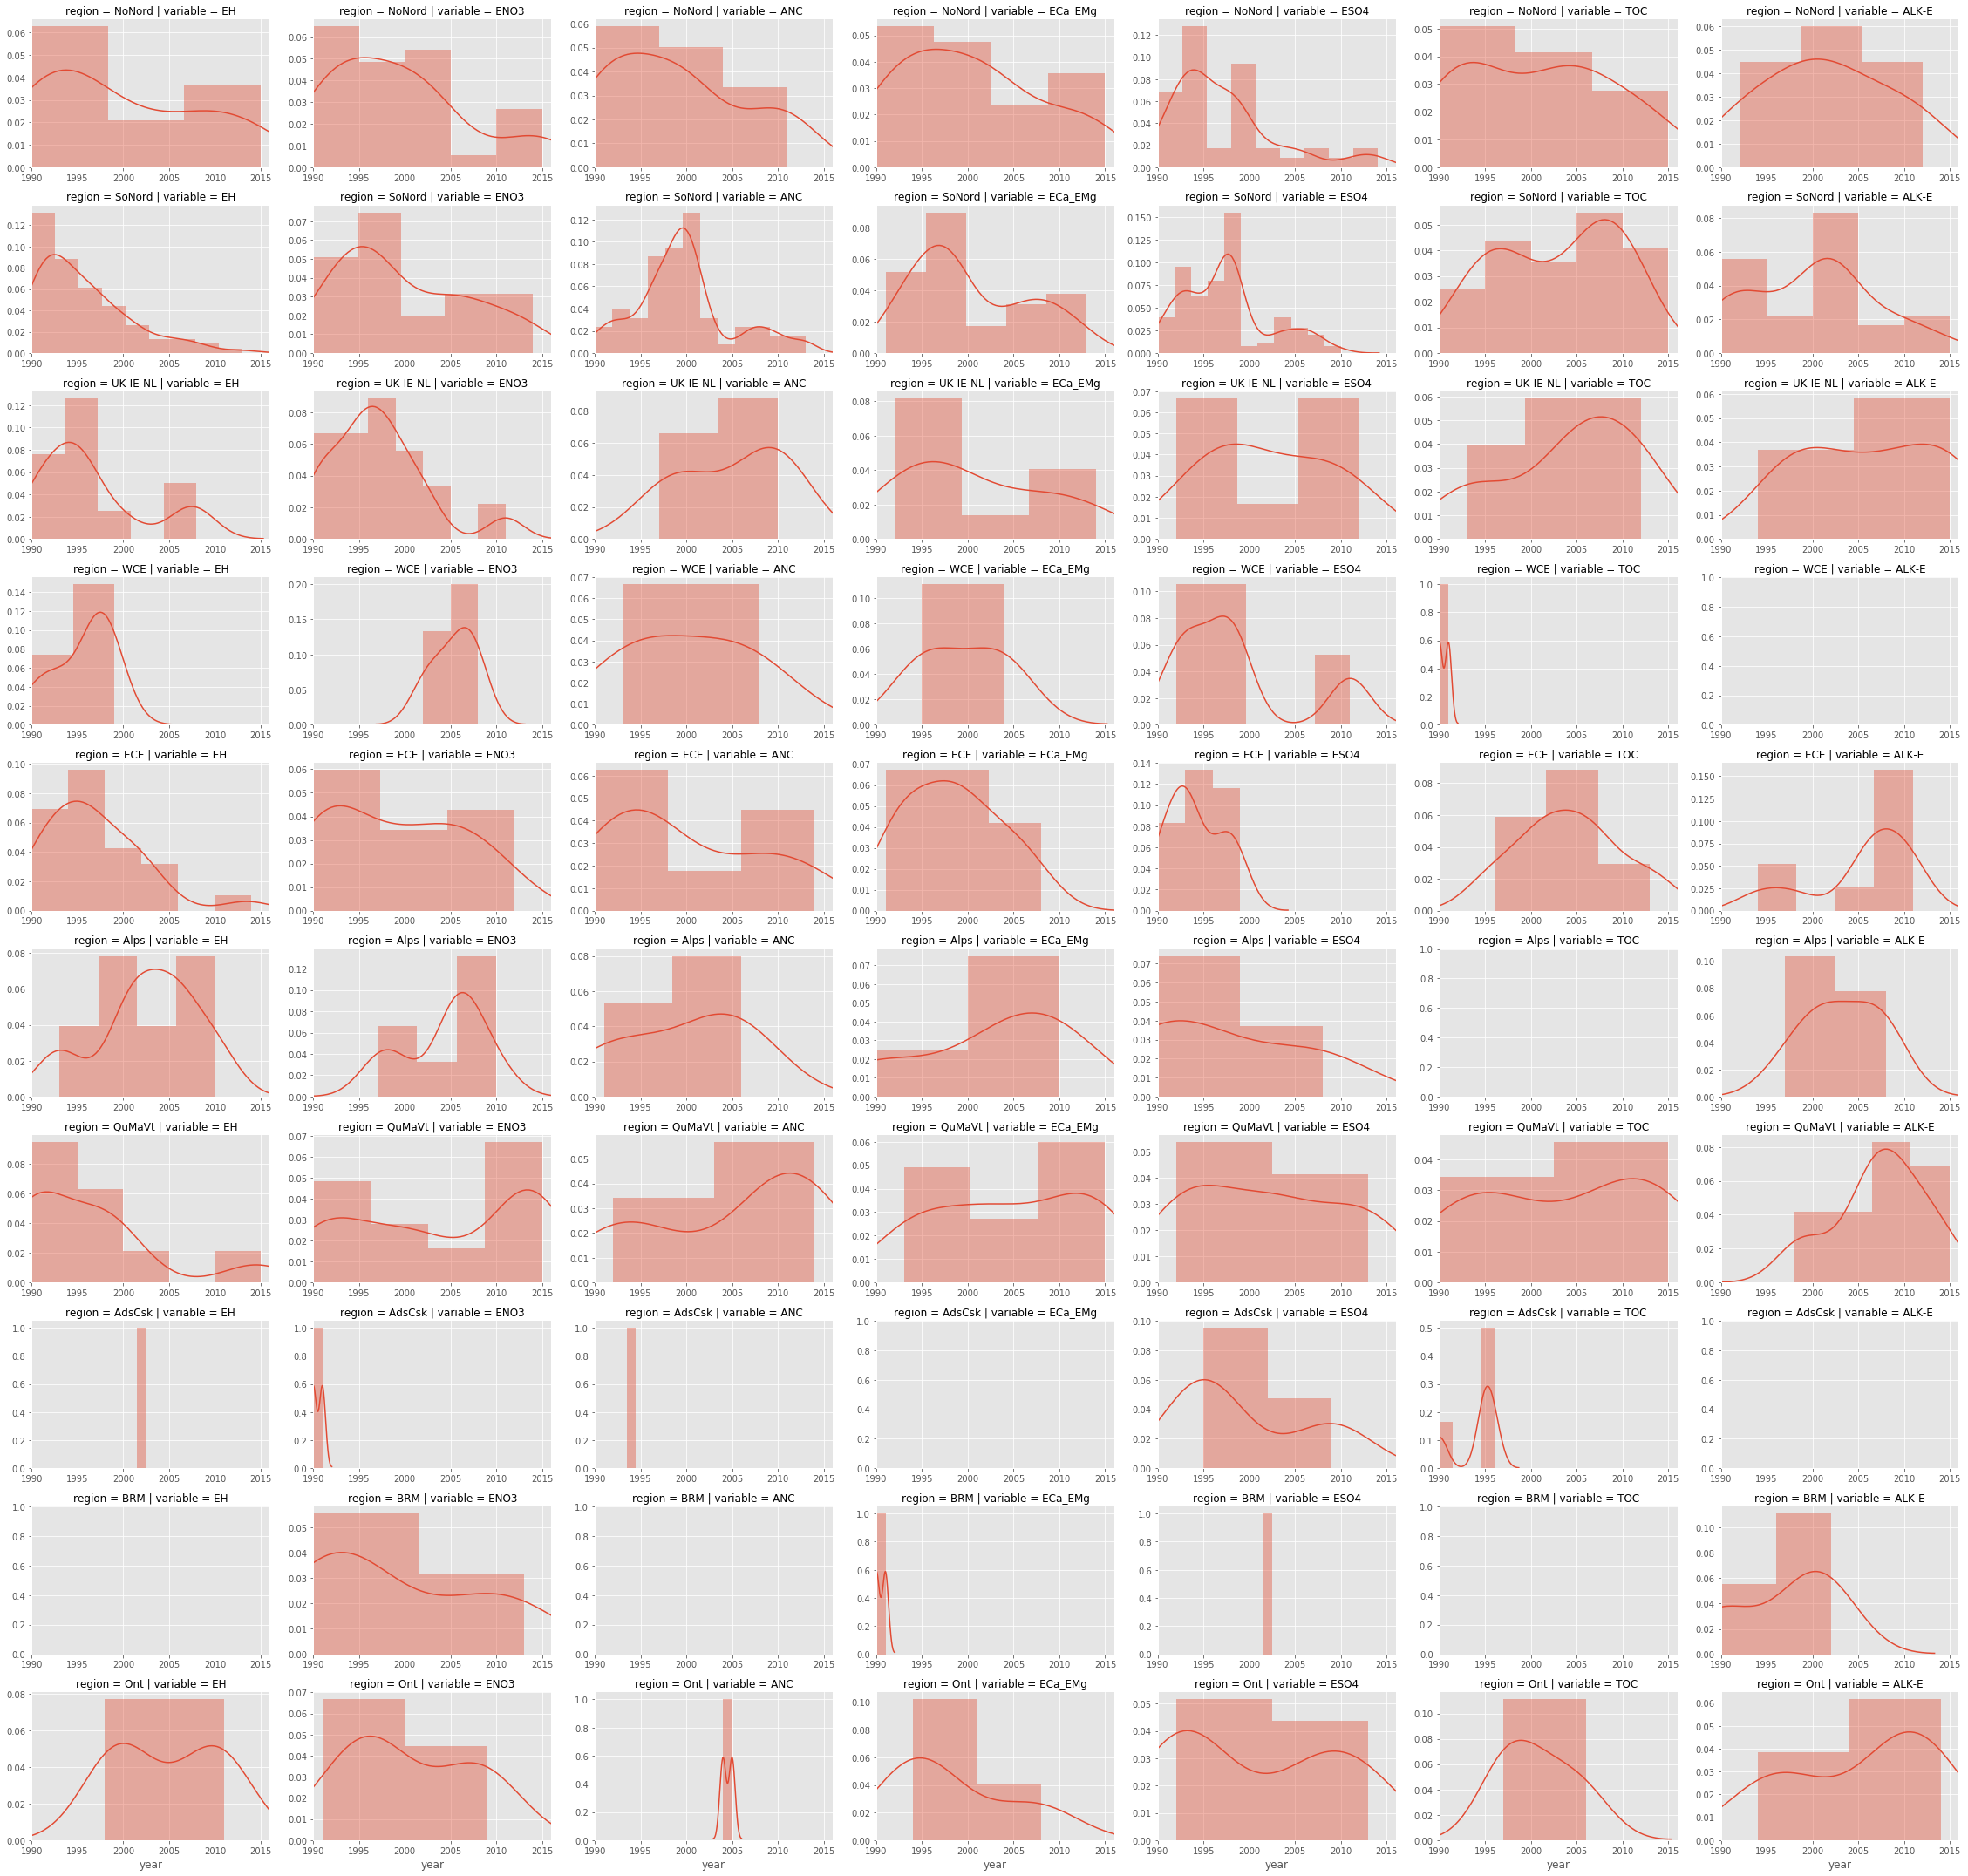

In [24]:
# KDE-smoothed plots by region
# Change prob > 75%
gt50_df = res_bcp.query('prob == "gt75"')

g = sn.FacetGrid(gt50_df,
                 row='region',
                 col='variable',
                 aspect=1.5,
                 sharex='row',
                 sharey=False,
                 row_order=['NoNord', 'SoNord', 'UK-IE-NL', 
                            'WCE', 'ECE', 'Alps', 'QuMaVt',
                            'AdsCsk', 'BRM', 'Ont'])
g.map(sn.distplot, 'year')
g.set(xlim=(1990, 2016))

# Save
out_png = os.path.join(out_fold, 'change_prob_kde_gt75_by_region_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

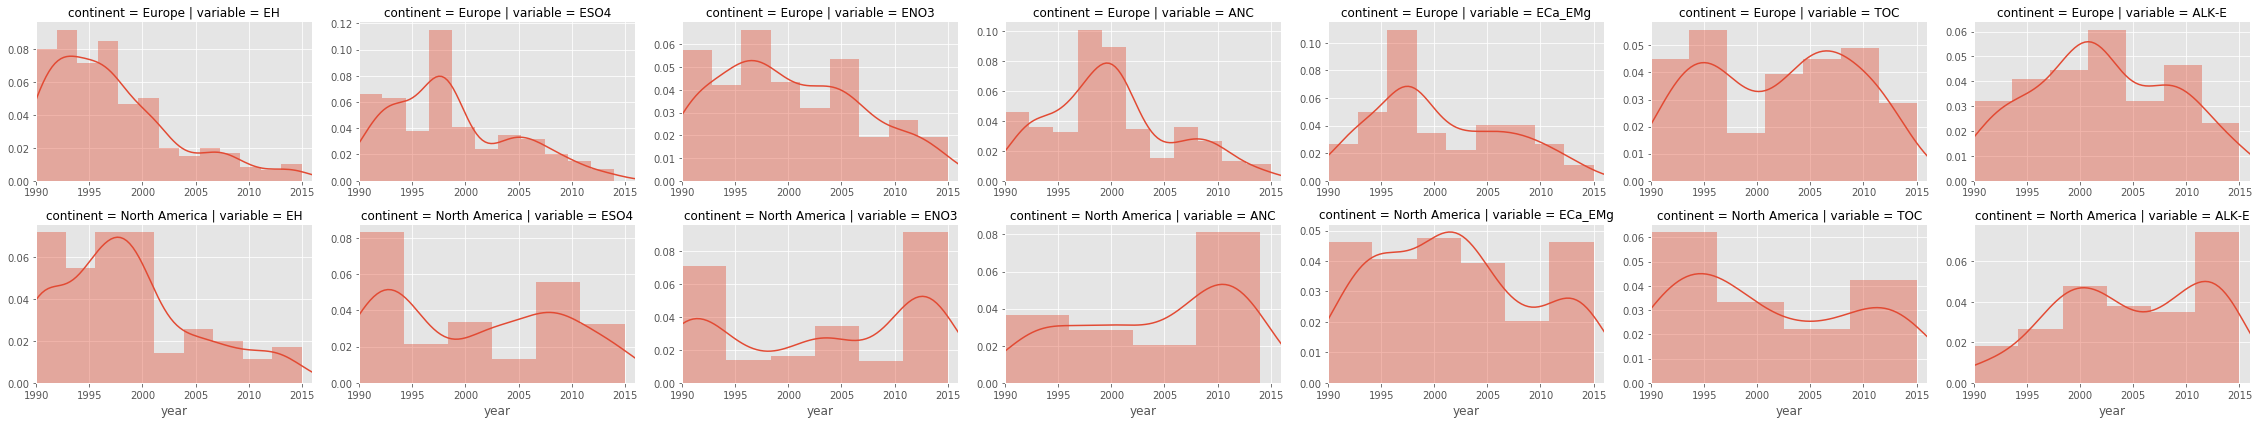

In [25]:
# KDE-smoothed plots by continent
# Change prob > 50%
gt50_df = res_bcp.query('prob == "gt50"')

g = sn.FacetGrid(gt50_df,
                 row='continent',
                 col='variable',
                 aspect=1.5,
                 sharex='row',
                 sharey=False)
g.map(sn.distplot, 'year')
g.set(xlim=(1990, 2016))

# Save
out_png = os.path.join(out_fold, 'change_prob_kde_gt50_by_continent_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

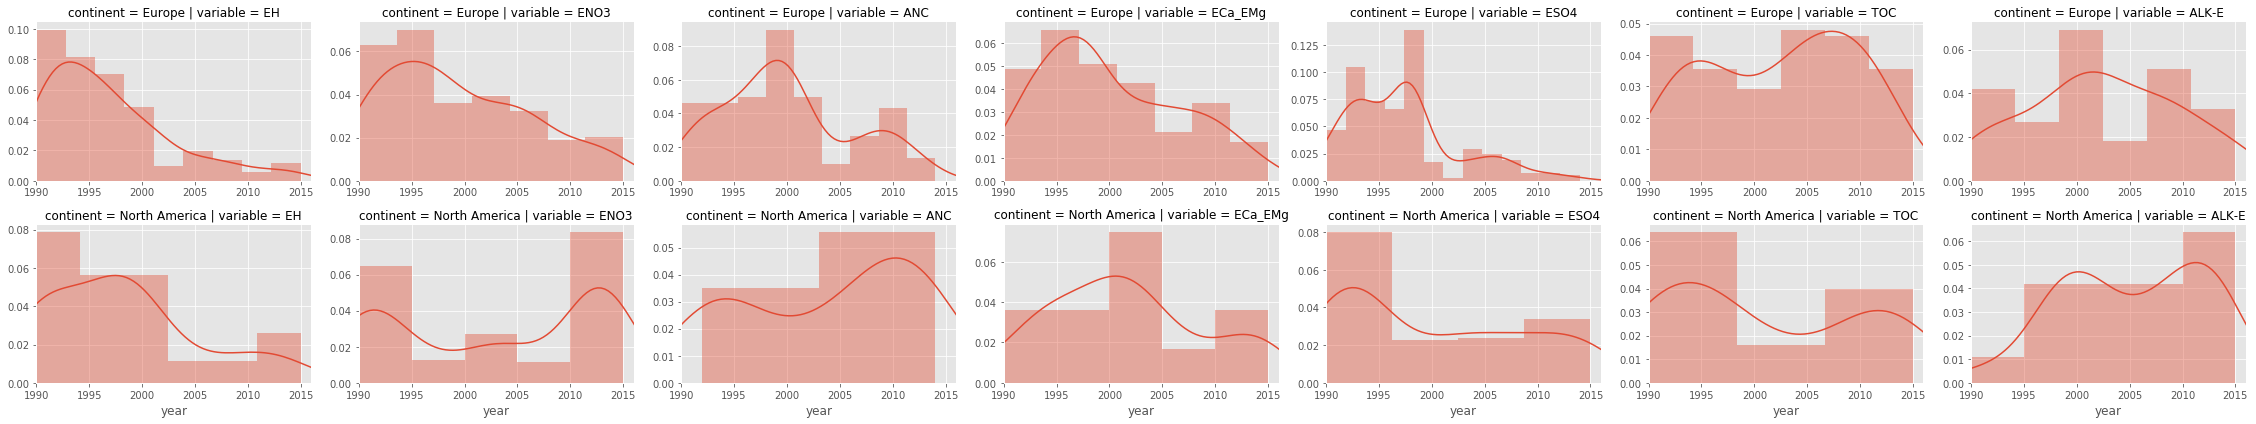

In [26]:
# KDE-smoothed plots by continent
# Change prob > 75%
gt50_df = res_bcp.query('prob == "gt75"')

g = sn.FacetGrid(gt50_df,
                 row='continent',
                 col='variable',
                 aspect=1.5,
                 sharex='row',
                 sharey=False)
g.map(sn.distplot, 'year')
g.set(xlim=(1990, 2016))

# Save
out_png = os.path.join(out_fold, 'change_prob_kde_gt75_by_continent_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

I haven't had time to look at this output in detail, but there appears to be evidence for consistent regional changes in at least some variables. For example, ENO3X, ECaX_EMgX and ESO4X all show similar patterns in the SoNord, NoNord and UK+IE+NL regions (and perhaps for Europe as a whole too), with many change points occurring in the mid-1990s. For TOC, meanwhile, the most common European change points are about a decade later, in the mid-2000s.

## 6. Differences between medians and minima

**Added 02/06/2019.**

Øyvind would like to explore trends in the absolute differences between annual median and minimum values for ANC and pH. This is motivated by some interesting patterns previously documented at Øygardsbekken (station ID 38313) - see e-mail from Øyvind received 01/06/2019 at 17.47 for details.

As a sanity check, it's a good idea to first make sure I can reproduce the patterns in Øyvind's e-mail.

In [27]:
# Load series
pkl = os.path.join(out_fold, 'series_relaxed_criteria.pkl')
with open(pkl, 'rb') as handle:
    series_dict = pickle.load(handle)
    
# Get data for Øygardsbekken
stn_id = 38313

# Loop over dfs
df_list = []

for par in ['ANC', 'EH']:
    # Get data
    df = series_dict[(stn_id, par)]   
    
    # Convert EH to pH
    if par == 'EH':
        df['value'] = -np.log10(df['value']/1E6) 
        par = 'pH'
        
    # Resample to annual medians and mins
    for col_idx, stat in enumerate(['annual median', 'annual minimum']):
        if stat == 'annual median':
            df_stat = df.resample('A').median()
        else:
            df_stat = df.resample('A').min()

        df_stat['year'] = df_stat.index.year
        df_stat['metric'] = stat
        df_stat['variable'] = par
        df_stat.reset_index(inplace=True, drop=True)
            
        df_list.append(df_stat)
        
ann_df = pd.concat(df_list, axis=0)        
ann_df.head()

,value,year,metric,variable
0,-51.247305,1992,annual median,ANC
1,-82.105765,1993,annual median,ANC
2,-31.137920,1994,annual median,ANC
3,-40.616714,1995,annual median,ANC
4,-33.383755,1996,annual median,ANC


(4, 6)

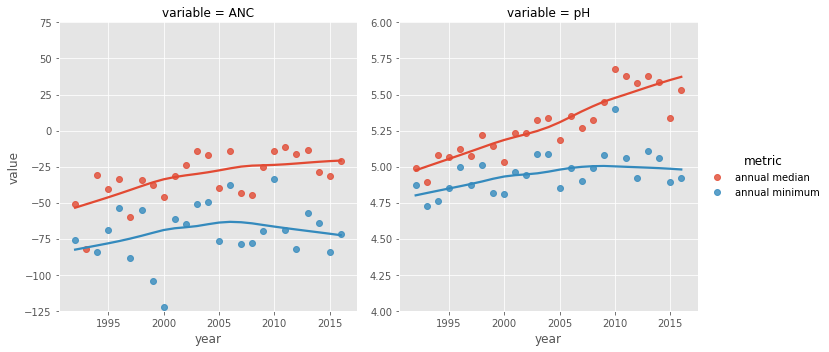

In [28]:
# Plot
g = sn.lmplot(x='year', 
              y='value', 
              data=ann_df,
              col='variable',
              hue='metric',
              sharey=False,
              lowess=True)

g.axes[0, 0].set_ylim((-125, 75))
g.axes[0, 1].set_ylim((4, 6))

These plots look the same as in Øyvind's e-mail, which is good. The difference between minimum and median ANC looks fairly steady, whereas differences for pH are becoming larger through time, apparently because median pH is increasing more rapidly than minimum pH. The next step is to calculate absolute differences between median and minimum values for all sites and then test for trends.

In [29]:
%%capture
# Load series
pkl = os.path.join(out_fold, 'series_relaxed_criteria.pkl')
with open(pkl, 'rb') as handle:
    series_dict = pickle.load(handle)
    
# Dicts for results
res_dict = {'station_id':[],
            'variable':[],
            'mk_p_val':[],
            'mk_trend':[],
            'sen_slp':[],
            'sen_incpt':[],
            'sen_trend':[],
           }

for stn_id in inc_df['station_id'].unique():
    for par in ['ANC', 'EH']:
        try:
            # Get data
            df = series_dict[(stn_id, par)]   

            # Convert EH to pH
            if par == 'EH':
                df['value'] = -np.log10(df['value']/1E6) 
                par = 'pH'

            # Resample to annual medians and mins
            df_med = df.resample('A').median()
            df_min = df.resample('A').min()
            df_diff = df_med - df_min
            df_diff.index = df_diff.index.year

            # MK test
            mk_df = nivapy.stats.mk_test(df_diff, 'value')

            # Sen's slope
            res_df, sen_df = nivapy.stats.sens_slope(df_diff, 
                                                     value_col='value',
                                                     index_col=df_diff.index)

            # Add results to dict
            res_dict['station_id'].append(stn_id)
            res_dict['variable'].append(par)
            res_dict['mk_p_val'].append(mk_df.loc['p'].value)
            res_dict['mk_trend'].append(mk_df.loc['trend'].value)

            sslp = res_df.loc['sslp'].value
            sincpt = res_df.loc['icpt'].value
            res_dict['sen_slp'].append(sslp)
            res_dict['sen_incpt'].append(sincpt)
            res_dict['sen_trend'].append(res_df.loc['trend'].value)
                                       
        except KeyError:
            pass

# Combine results
res_df = pd.DataFrame(res_dict)
out_csv = os.path.join(out_fold, 'trends_in_differences_relaxed_criteria.csv')
res_df.to_csv(out_csv, index=False, encoding='utf-8')

In [30]:
res_df.head()

,station_id,variable,mk_p_val,mk_trend,sen_slp,sen_incpt,sen_trend
0,23472,ANC,0.481774,no trend,0.028164,-54.284790,no trend
1,23472,pH,0.004313,increasing,0.005417,-10.800417,increasing
2,23505,ANC,0.637438,no trend,-0.210821,454.722677,no trend
3,23505,pH,0.006670,decreasing,-0.026905,54.358333,decreasing
4,23506,pH,0.004050,decreasing,-0.035748,72.617222,decreasing


As a further quick check, here are the results for Øygardsbekken:

In [31]:
# Get results for Øygardsbekken
res_df.query('station_id == 38313')

,station_id,variable,mk_p_val,mk_trend,sen_slp,sen_incpt,sen_trend
713,38313,ANC,2.157853e-01,no trend,0.687044,-1340.522993,no trend
714,38313,pH,7.221532e-07,increasing,0.016603,-32.951538,increasing


As expected, there is no trend for differences in ANC, but a significant increasing trend for differences in pH.

Next, join in the region data and explore patterns for all sites.

In [32]:
# Just significant
df = res_df.query("sen_trend in ('increasing', 'decreasing')")

# Join regions
df = pd.merge(df, stn_df[['station_id', 'continent', 'country', 'region']],
              how='left', on='station_id')

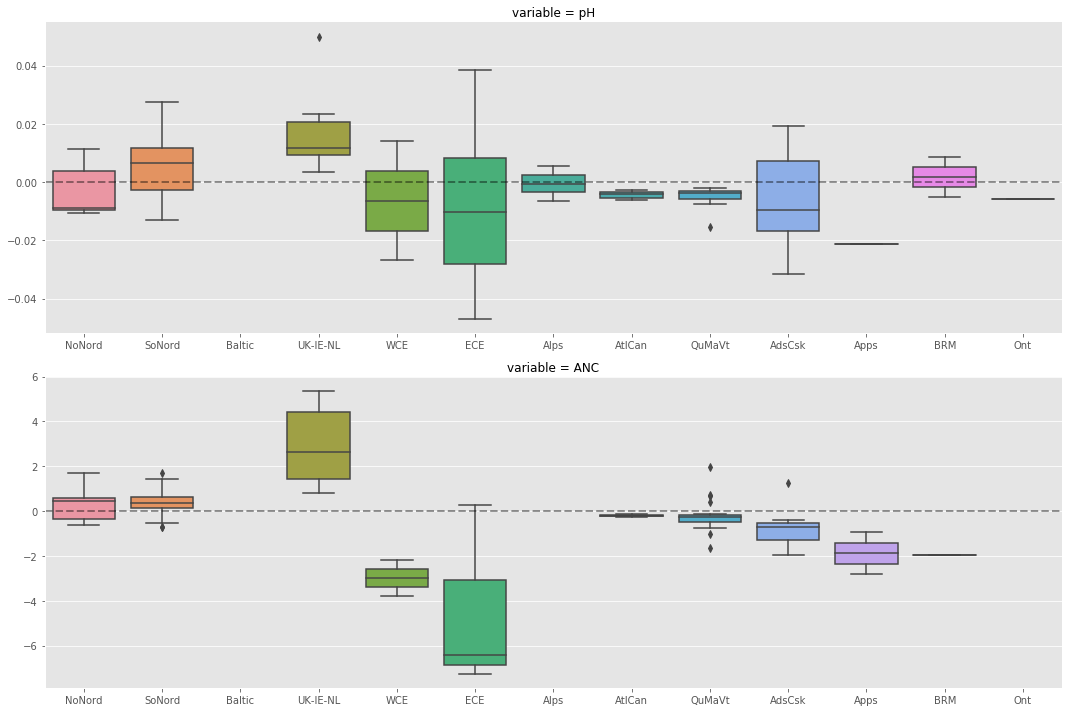

In [33]:
# Box plots of significant slopes in differences by region
g = sn.catplot(data=df,
               x='region',
               y='sen_slp',
               row='variable',
               kind='box', 
               order=['NoNord', 'SoNord', 'Baltic', 'UK-IE-NL', 
                      'WCE', 'ECE', 'Alps', 'AtlCan', 'QuMaVt',
                      'AdsCsk', 'Apps', 'BRM', 'Ont'],
               sharex=False,
               sharey=False,
               aspect=3,
              ) 

g.map(plt.axhline, y=0, lw=2, ls='--', c='k', alpha=0.4)

# Save
out_png = os.path.join(out_fold, 'med_min_diff_box_plots_by_region_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)

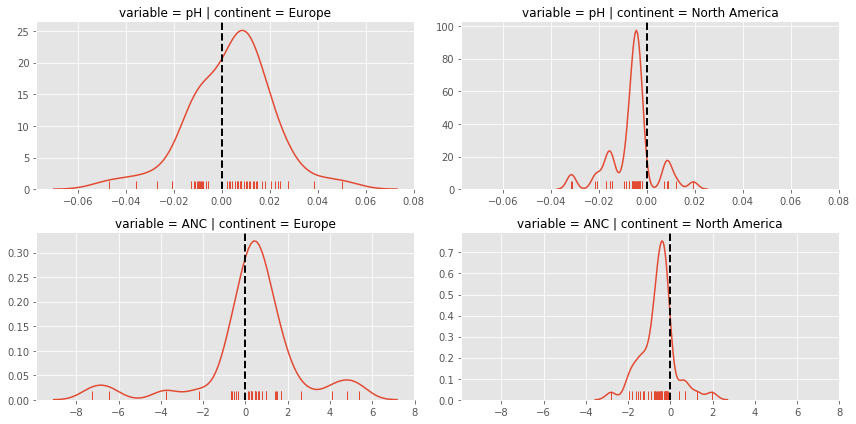

In [34]:
# KDE-smoothed plots by continent
g = sn.FacetGrid(df,
                 row='variable',
                 col='continent',
                 aspect=2,
                 sharex='row',
                 sharey=False)
g.map(sn.distplot, 'sen_slp', hist=False, rug=True)
g.map(plt.axvline, x=0, lw=2, ls='--', c='k')

# Save
out_png = os.path.join(out_fold, 'med_min_diff_kde_plots_by_continent_relaxed_criteria.png')
plt.savefig(out_png, dpi=200)